In [1]:
import os
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional
from xopt.vocs import VOCS

# Load Measurement Data

In [2]:
files = {
    "nn": [
        "optimization_nn_3_high_n_restarts.yml",
        "optimization_nn_4_high_n_restarts.yml",
        "optimization_nn_5_high_n_restarts.yml",
        "optimization_nn_6_high_n_restarts.yml",
        "optimization_nn_7_high_n_restarts.yml",
    ],
    "nn_max_tvl": [
        "optimization_nn_8_high_n_restarts_max_tvl.yml",
        "optimization_nn_9_high_n_restarts_max_tvl.yml",
        "optimization_nn_7_high_n_restarts_max_tvl.yml",
        "optimization_nn_10_high_n_restarts_max_tvl.yml",
    ],
    "turbo": [
        "optimization_5_high_n_restarts_turbo.yml",
        "optimization_4_high_n_restarts_turbo.yml",
        "optimization_6_high_n_restarts_turbo.yml",
        "optimization_7_high_n_restarts_turbo.yml",
        "optimization_8_high_n_restarts_turbo.yml",
        "optimization_9_high_n_restarts_turbo.yml",
        "optimization_10_high_n_restarts_turbo.yml",
    ],
    "max_tvl": [
        "optimization_8_high_n_restarts_max_tvl.yml",
        "optimization_6_high_n_restarts_max_tvl.yml",
        "optimization_7_high_n_restarts_max_tvl.yml",
        "optimization_10_high_n_restarts_max_tvl.yml",
    ]
}


def select_data(data_name: str, f_name: str) -> bool:
    if data_name not in files.keys():
        return f_name.endswith(".yml")
    else:
        return f_name in files[data_name]

In [3]:
data_name = "all"
data_dir = "../../run_data/2023_06_19/"

vocs = None
f_names, dfs = [], []
for filename in os.listdir(data_dir):
    if select_data(data_name, filename):
        f_name = os.path.join(data_dir, filename)
        if os.path.isfile(f_name):
            f_names.append(filename)
            with open(f_name, "r") as file:
                f = yaml.safe_load(file)
                dfs.append(pd.DataFrame(f["data"]))
                if vocs is None:
                    vocs = VOCS(**f["vocs"])

# Define Calculation of Correlation and MAE

In [4]:
def calc_corr(a: torch.Tensor, b: torch.Tensor,
              cutoff_value: Optional[float] = None) -> torch.Tensor:
    """Calculates the correlation between the given tensors.

    Args:
        a: First tensor.
        b: Second tensor.
        cutoff_value: If not None, data samples are only used if the value in
          the first tensor is above the given value.
    """
    if cutoff_value is not None:
        a_c = a[torch.where(a > cutoff_value)[0]]
        b_c = b[torch.where(a > cutoff_value)[0]]
    else:
        a_c, b_c = a, b
    corr = torch.corrcoef(torch.stack([a_c.squeeze(), b_c.squeeze()]))
    return corr[0, 1]


def calc_mae(a: torch.Tensor, b: torch.Tensor,
             cutoff_value: Optional[float] = None) -> torch.Tensor:
    """Calculates the mean absolute error between the given tensors.

    Args:
        a: First tensor.
        b: Second tensor.
        cutoff_value: If not None, data samples are only used if the value in
          the first tensor is above the given value.
    """
    if cutoff_value is not None:
        a_c = a[torch.where(a > cutoff_value)[0]]
        b_c = b[torch.where(a > cutoff_value)[0]]
    else:
        a_c, b_c = a, b
    return torch.nn.functional.l1_loss(a_c, b_c)

# Load Surrogate Model

In [5]:
class TransformedModel(torch.nn.Module):
    def __init__(self, model, x_transformer, y_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
    
    def forward(self, x):
        x = self.x_transformer(x)
        x = self.model(x)
        x = self.y_transformer.untransform(x)
        return x


# wrap in AWA model to perform scaling
class AWAModel(torch.nn.Module):
    def __init__(self, base_model):
        super(AWAModel, self).__init__()
        self.model = base_model
        
    def forward(self, x):
        #add phase
        x[:, -1] = x[:, -1] - 103
        result = self.model(x).squeeze(dim=-1) + 57.224
        return result

    
class PhaseAdjustedModel(torch.nn.Module):
    def __init__(self, base_model):
        super(PhaseAdjustedModel, self).__init__()
        self.model = base_model
        
    def forward(self, x):
        #add phase
        x[:, -1] = x[:, -1] - 103
        result = self.model(x).squeeze(dim=-1)
        return result

In [6]:
model = AWAModel(base_model=torch.load("fitted_model.pt"))
# model = PhaseAdjustedModel(base_model=torch.load("unused_models/ok2.pt"))
# model = PhaseAdjustedModel(base_model=torch.load("unused_models/ok-ss.pt"))

model.eval()
model.requires_grad_(False)
model

AWAModel(
  (model): TransformedModel(
    (model): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
    (x_transformer): Normalize()
    (y_transformer): Normalize()
  )
)

# Evaluate Correlations and MAE

In [7]:
corrs, maes = [], []
ys, preds = [], []

for i in range(len(dfs)):
    df = dfs[i][vocs.variable_names + vocs.objective_names]
    df = df.dropna(subset=vocs.objective_names)
    x = torch.from_numpy(df[vocs.variable_names].to_numpy())
    y = torch.from_numpy(df[vocs.objective_names].to_numpy()).squeeze()
    ys.append(y)
    pred = model(x)
    preds.append(pred)
    corr, mae = calc_corr(pred, y), calc_mae(pred, y)
    corrs.append(corr.item())
    maes.append(mae.item())

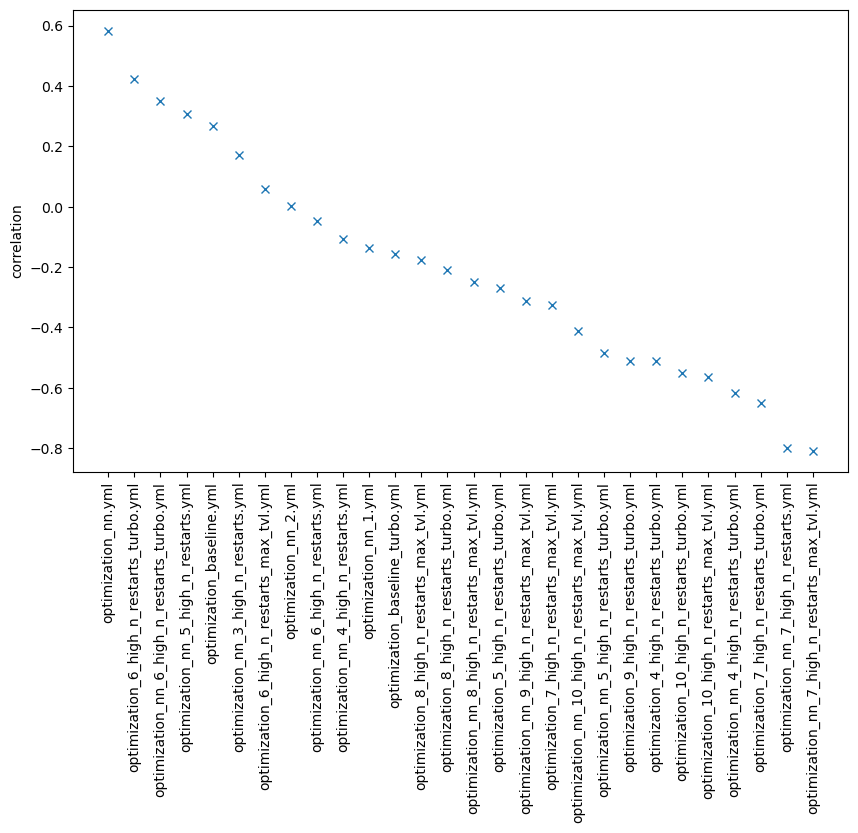

In [8]:
sort_idx = np.argsort(corrs)[::-1]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
axis = np.arange(len(corrs))
ax.plot(axis, np.array(corrs)[sort_idx], "x")
ax.set_xticks(axis)
ax.set_xticklabels(np.array(f_names)[sort_idx], rotation='vertical')
ax.set_ylabel("correlation");

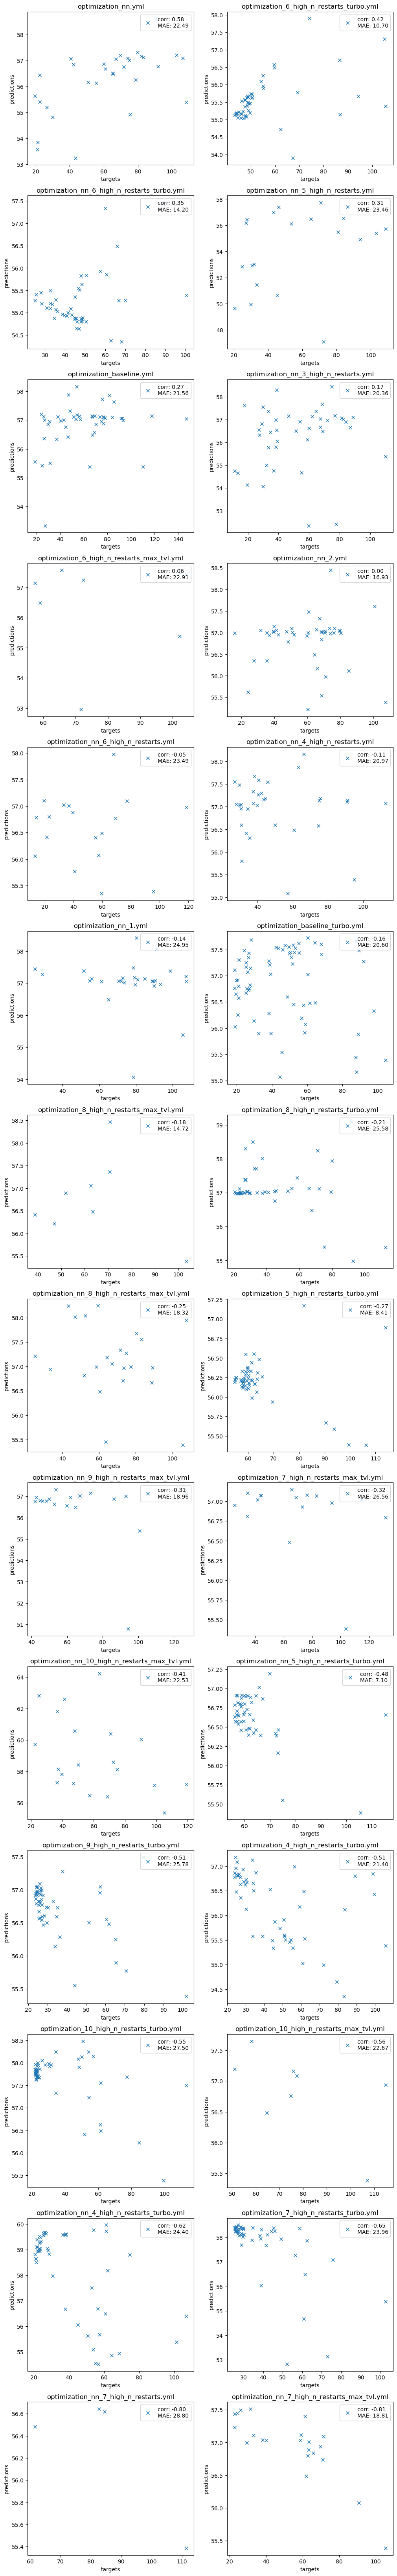

In [ ]:
sort_idx = np.argsort(corrs)[::-1]
ncols = 2
nrows = len(dfs) // ncols
if ncols * nrows < len(dfs):
    nrows += 1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 6 * nrows))
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i < len(dfs):    
        j = sort_idx[i]
        ax_i.plot(ys[j], preds[j], "x", label="corr: {:.2f}\nMAE: {:.2f}".format(corrs[j], maes[j]))
        ax_i.set_title(f_names[j])
        ax_i.set_xlabel("targets")
        ax_i.set_ylabel("predictions")
        ax_i.legend(loc=1)
    else:
        ax_i.axis('off')

# Performance

In [ ]:
def running_max(y: torch.Tensor) -> torch.Tensor:
    """Returns the running maximum for the given data.

    The respective maxima are formed over the last dimension.

    Args:
        y: Data for which the running maximum/maxima shall be calculated.

    Returns:
        The running maximum for the given data.
    """
    y_opt = torch.stack([torch.max(y[..., :i + 1], dim=-1)[0] for i in range(y.shape[-1])])
    p = 1 + torch.arange(len(y_opt.shape))
    p[-1] = 0
    return torch.permute(y_opt, p.tolist())


def running_min(y: torch.Tensor) -> torch.Tensor:
    return -running_max(-y)

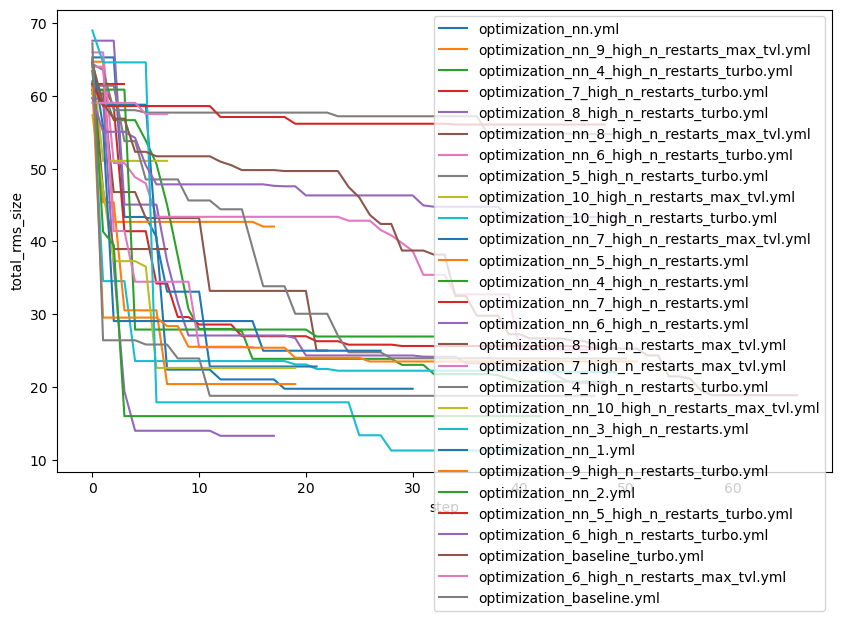

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
for i in range(len(dfs)):
    ax.plot(np.arange(len(ys[i])), running_min(ys[i]), "-", label=f_names[i])
    ax.set_xlabel("step")
    ax.set_ylabel(vocs.objective_names[0])
    ax.legend(loc=1)

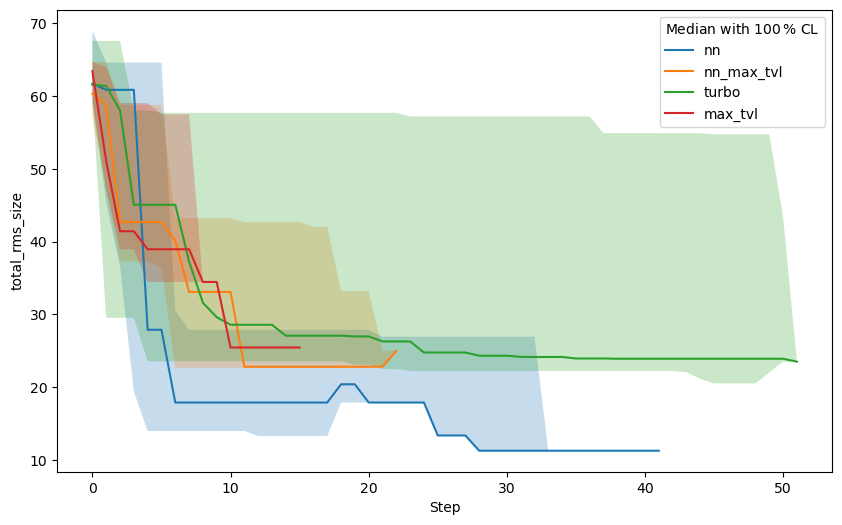

In [12]:
confidence_level = 1.0
q = (1 - confidence_level) / 2.0

names = []
m, lb, ub = [], [], []
for d_name in files.keys():
    data = []
    for i, f_name in enumerate(f_names):
        if select_data(d_name, f_name):
            data.append(running_min(ys[i]))
    if data:
        y = torch.full((len(data), max([len(entry) for entry in data])), torch.nan)
        for i, run_data in enumerate(data):
            y[i, :len(run_data)] = run_data
        names.append(d_name)
        m.append(torch.nanmedian(y, dim=0)[0])
        lb.append(torch.nanquantile(y, q=q, dim=0))
        ub.append(torch.nanquantile(y, q=1-q, dim=0))

# plot data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
for i, d_name in enumerate(names):
    axis = np.arange(len(m[i]))
    ax.plot(axis, m[i], label=d_name)
    ax.fill_between(axis, lb[i], ub[i], alpha=0.25)

ax.set_xlabel("Step")
ax.set_ylabel(vocs.objective_names[0])
ax.legend(loc=1, alignment="left", title="Median with {:.0f}$\,$% CL".format(100 * confidence_level));

# Correlation of Aggregated Data

In [13]:
agg_dfs, agg_names = [], []
for d_name in files.keys():
    agg_df = None
    for i, f_name in enumerate(f_names):
        if select_data(d_name, f_name):
            if agg_df is None:
                agg_df = dfs[i]
            else:
                agg_df = pd.concat([agg_df, dfs[i]])
    agg_dfs.append(agg_df)
    agg_names.append(d_name)

In [14]:
agg_corrs, agg_maes = [], []
agg_ys, agg_preds = [], []

for i in range(len(agg_dfs)):
    df = agg_dfs[i][vocs.variable_names + vocs.objective_names]
    df = df.dropna(subset=vocs.objective_names)
    x = torch.from_numpy(df[vocs.variable_names].to_numpy())
    y = torch.from_numpy(df[vocs.objective_names].to_numpy()).squeeze()
    agg_ys.append(y)
    pred = model(x)
    agg_preds.append(pred)
    corr, mae = calc_corr(pred, y), calc_mae(pred, y)
    agg_corrs.append(corr.item())
    agg_maes.append(mae.item())

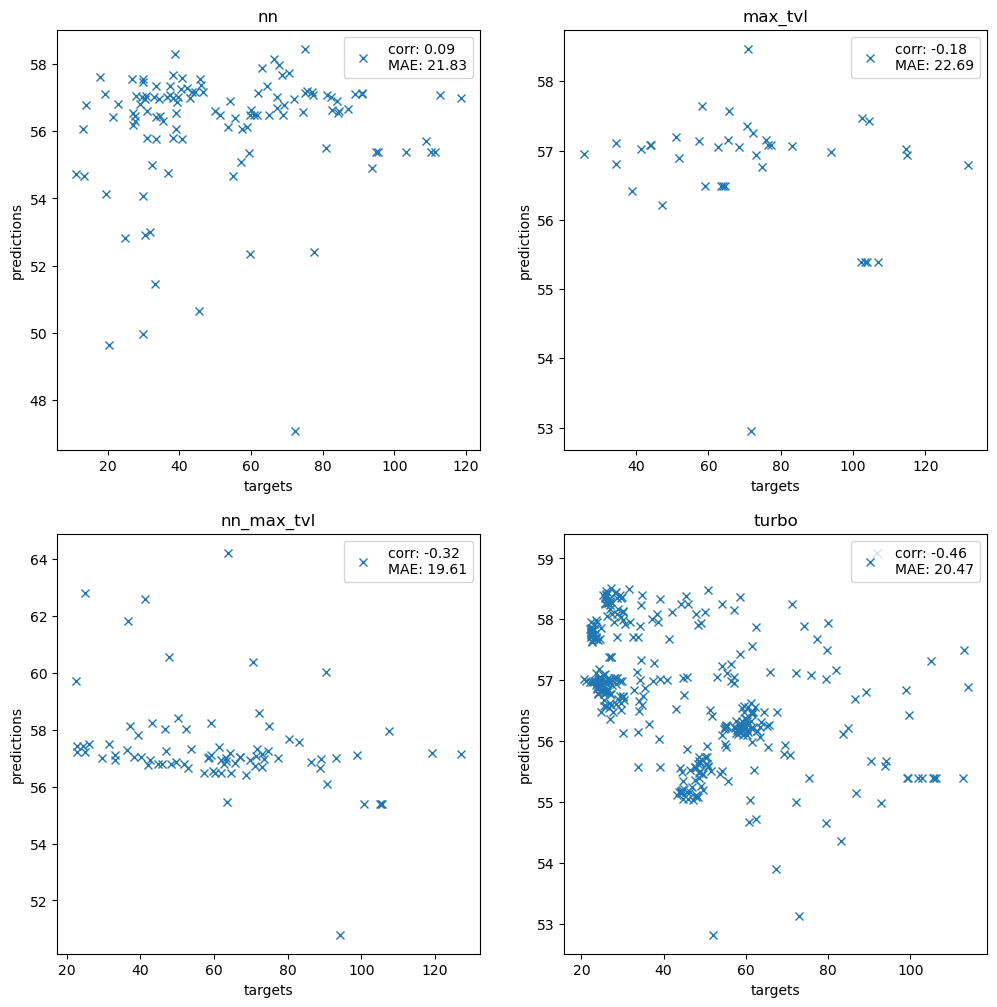

In [15]:
sort_idx = np.argsort(agg_corrs)[::-1]
ncols = 2
nrows = len(agg_dfs) // ncols
if ncols * nrows < len(agg_dfs):
    nrows += 1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 6 * nrows))
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i < len(dfs):    
        j = sort_idx[i]
        ax_i.plot(agg_ys[j], agg_preds[j], "x", label="corr: {:.2f}\nMAE: {:.2f}".format(agg_corrs[j], agg_maes[j]))
        ax_i.set_title(agg_names[j])
        ax_i.set_xlabel("targets")
        ax_i.set_ylabel("predictions")
        ax_i.legend(loc=1)
    else:
        ax_i.axis('off')

# Correlation between Repeated Measurements

In [16]:
folder = "../../run_data/2023_06_15/"
f_names = ["exploration_2_nd_filter.yml", "optimization_1.yml", "optimization_2.yml"]
dfs = []
for name in f_names:
    with open(folder + name, "r") as file:
        f = yaml.safe_load(file)
        dfs += [pd.DataFrame(f["data"])]

data = pd.concat(dfs, ignore_index=True)
data = data.dropna(subset=["total_rms_size"])
data["total_rms_size"] = data["total_rms_size"]

old_vocs = VOCS(**f["vocs"])

sorted_idx = np.argsort(data["total_rms_size"].to_numpy())
old_samples = data[vocs.variable_names + vocs.objective_names].iloc[sorted_idx[:30]]

# account for phase drift 103 deg
old_samples["AWALLRF:K1:SetPhase"] = old_samples["AWALLRF:K1:SetPhase"] + 103
# old_samples

In [17]:
new_samples = pd.read_csv(data_dir + "repeat_meas.txt", sep="\t")
new_samples = new_samples[vocs.variable_names + vocs.objective_names].iloc[:-1]
# new_samples

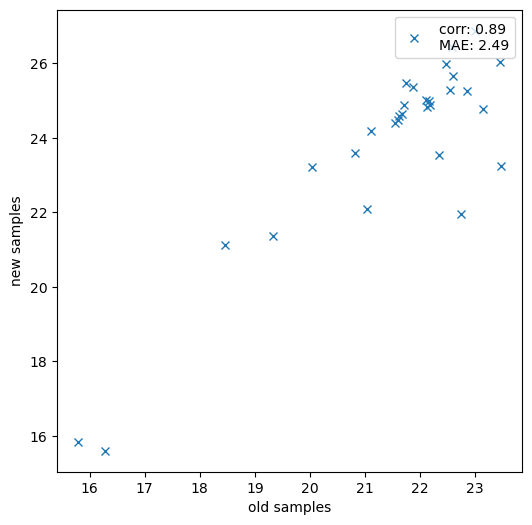

In [18]:
y_old = torch.from_numpy(old_samples[vocs.objective_names[0]].values)
y_new = torch.from_numpy(new_samples[vocs.objective_names[0]].values)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(y_old, y_new, "x", label="corr: {:.2f}\nMAE: {:.2f}".format(
    calc_corr(y_old, y_new), calc_mae(y_old, y_new)))
ax.set_xlabel("Repeated Measurements")
ax.set_xlabel("old samples")
ax.set_ylabel("new samples")
ax.legend(loc=1);